#Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding and you should consider doing some region processing after segmentation to improve the result.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a good result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_


In [70]:
import skimage.util as util
import skimage.io as io
import skimage.color as color
import skimage.filters as filt
import skimage.exposure as ex
import skimage.segmentation as seg
import skimage.morphology as morph
import numpy as np
import os as os
import matplotlib.pyplot as plt
from skimage.future import graph as graph
from skimage.feature import canny
from scipy import ndimage

# You can import other modules as needed.

def segleaf(I):
    '''
    Segment a leaf image.
    :param I: Color leaf image to segment.
    :return: Logical image where True pixels represent foreground (i.e. leaf pixels).
    '''
    if I.dtype == "uint8":
        I = util.img_as_float(I)
    
    greeness = np.ndarray((I.shape[0],I.shape[1]))
    R = abs(I[:,:,0])
    G = abs(I[:,:,1])*1.75
    B = abs(I[:,:,2])*1.1
            
    greeness[:,:] = G - (R + B)
    
    booled = np.ndarray((I.shape[0],I.shape[1]),dtype="bool")
    booled[greeness > 0] = 1
    booled[greeness <= 0] = 0
    

    booled_f = filt.median(booled,selem=morph.square(5))
    booled_f = morph.remove_small_objects(booled_f,min_size=2500)
    booled_f = filt.gaussian(booled_f,sigma=3)
    
    booled[booled_f > 0.5] = 1
    booled[booled_f <= 0.5] = 0
    
    d = morph.dilation(booled,selem=morph.disk(3))
    booled = morph.remove_small_holes(d,min_size=2500)
    booled = morph.erosion(booled,selem=morph.disk(3))
    
    L,blobs = ndimage.label(booled)
    num = np.bincount(L.ravel())[1:]
    sizeList = dict(zip(range(blobs),num))

    leafLabel = 0
    leafSize = 0
    for i in range(0,len(sizeList)):
        curVal = sizeList[i]
        if curVal > leafSize:
            leafLabel = i
            leafSize = curVal

    
    L[L != leafLabel+1] = 0
    return L
'''
testFile = io.imread("images\image_0099.png")
pic = segleaf(testFile)
plt.figure()
plt.imshow(pic)
plt.show()
'''

'\ntestFile = io.imread("images\\image_0099.png")\npic = segleaf(testFile)\nplt.figure()\nplt.imshow(pic)\nplt.show()\n'

# Step 2: Implment Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [66]:
import math
import scipy.spatial.distance as eD
def d(b,g):
    dist = np.ndarray(b.shape[0])
    for j in b:
        for i in g:
            val = np.sqrt(eD.euclidean(j,i))
    #dist[:] = np.sqrt((b[i,0] - g[:,0])**2 + (b[i,1] - g[:,1])**2)
    return dist
   
 
def MSD(iBoundry,gtBoundry):
    
    d0 = np.subtract.outer(iBoundry[:,0],gtBoundry[:,0])
    d1 = np.subtract.outer(iBoundry[:,1],gtBoundry[:,1])
    
    dist = np.hypot(d0,d1)
    
    mins = np.min(dist,axis=1)
    sumOfMins = np.sum(mins,axis=0)
    
    return sumOfMins/iBoundry.shape[0]

def HD(iBoundry,gtBoundry):
 
    minG_0 = np.subtract.outer(iBoundry[:,0],gtBoundry[:,0])
    minG_1 = np.subtract.outer(iBoundry[:,1],gtBoundry[:,1])
    minG_d = np.hypot(minG_0,minG_1) 
    minGs = np.min(minG_d,axis=1)
    
    minA_0 = np.subtract.outer(gtBoundry[:,0],iBoundry[:,0])
    minA_1 = np.subtract.outer(gtBoundry[:,1],iBoundry[:,1])
    minA_d = np.hypot(minA_0,minA_1)
    minAs = np.min(minA_d,axis=1)
    
    maxA = np.max(minGs)
    maxG = np.max(minAs)
 
    return max(maxA,maxG)
   

def DSC(I,GT):

    overLap = np.logical_and(I >= 1,GT >= 1)

    numerator = 2*(overLap[overLap==True].size)
    denominator = I[I>=1].size + GT[GT>=1].size
    return numerator/denominator

'''
test = io.imread("images\image_0002.png")
pic = segleaf(test)
test2 = io.imread("groundtruth\\threshimage_0002.png")

iBoundry = np.where(seg.find_boundaries(test > 0,connectivity=2,mode='inner') > 0)
iBoundry = np.transpose(np.vstack(iBoundry))
gtBoundry = np.where(seg.find_boundaries(test2 > 0,connectivity=2,mode='inner') > 0)
gtBoundry = np.transpose(np.vstack(gtBoundry))

print(DSC(pic,test2))
'''

'\ntest = io.imread("images\\image_0002.png")\npic = segleaf(test)\ntest2 = io.imread("groundtruth\\threshimage_0002.png")\n\niBoundry = np.where(seg.find_boundaries(test > 0,connectivity=2,mode=\'inner\') > 0)\niBoundry = np.transpose(np.vstack(iBoundry))\ngtBoundry = np.where(seg.find_boundaries(test2 > 0,connectivity=2,mode=\'inner\') > 0)\ngtBoundry = np.transpose(np.vstack(gtBoundry))\n\nprint(DSC(pic,test2))\n'

# Step 3: Write a Validation driver program.

Write code that segments each image, and computes the MSD, HD, and DSC for each segmentation.  Print the MSD, HD, and DSC of each segmentation as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image (in the `images` folder):

* load the image and it's ground truth
* segment the input image - this should be a binary image with a single region (connected component).
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture nodes for an example on how to do this!).
* Compute the MSD and the HD from the two sets of boundary points (using the functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

C:\ProgramData\Anaconda3\lib\site-packages\skimage\morphology\misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


MSC for image_0001.png: 0.29139776215623653


HC for image_0001.png: 5.0990195135927845
DCS for image_0001.png: 0.9945722783900177


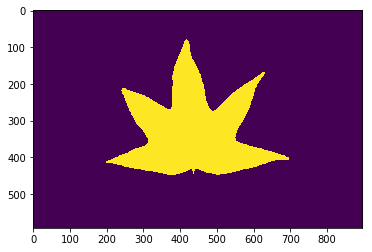

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0002.png: 0.34517858076183644


HC for image_0002.png: 97.32420048477151
DCS for image_0002.png: 0.9908740948125017


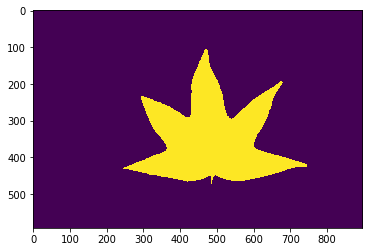

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0005.png: 0.3306057253888328


HC for image_0005.png: 8.0
DCS for image_0005.png: 0.9938905419247842


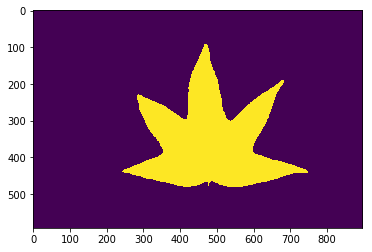

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0007.png: 0.35566143709511355


HC for image_0007.png: 4.123105625617661
DCS for image_0007.png: 0.9941776091479727


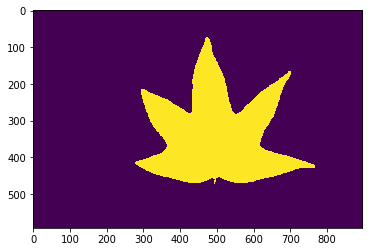

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0009.png: 0.3813705375391946


HC for image_0009.png: 6.082762530298219
DCS for image_0009.png: 0.9933692708728773


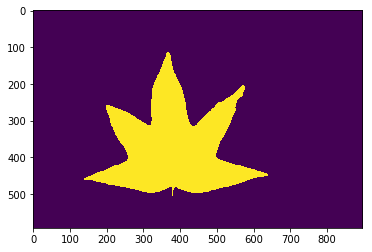

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0010.png: 0.25560198372475434


HC for image_0010.png: 11.045361017187261
DCS for image_0010.png: 0.9954654736906174


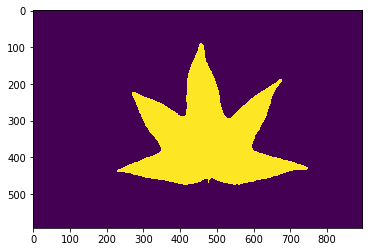

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0011.png: 0.32017192703732716


HC for image_0011.png: 97.86725703727473
DCS for image_0011.png: 0.9915496596961636


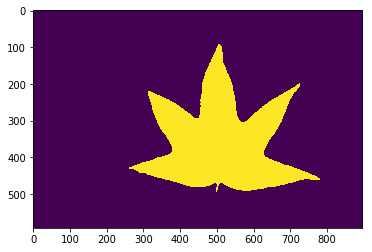

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0015.png: 0.43372729042459085


HC for image_0015.png: 7.280109889280518
DCS for image_0015.png: 0.9924665461855544


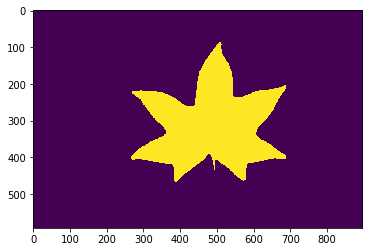

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0018.png: 0.6788444745978648


HC for image_0018.png: 12.165525060596439
DCS for image_0018.png: 0.9894942399015997


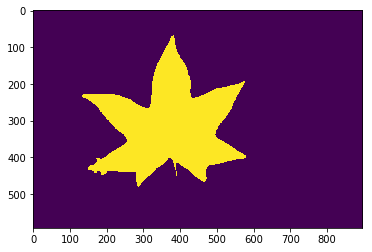

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0019.png: 0.37962096678894636


HC for image_0019.png: 4.47213595499958
DCS for image_0019.png: 0.9934941137219389


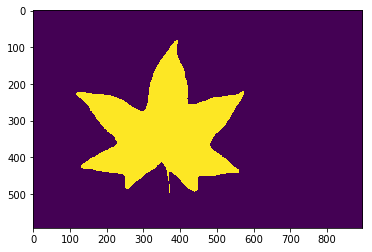

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0078.png: 0.2627193961080542
HC for image_0078.png: 4.47213595499958
DCS for image_0078.png: 0.9968156293721788


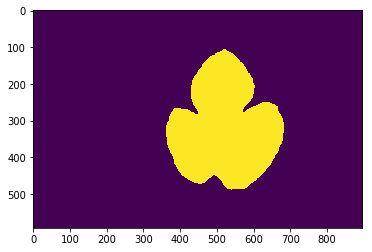

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0080.png: 0.35176638388549564
HC for image_0080.png: 4.47213595499958
DCS for image_0080.png: 0.9958701359517369


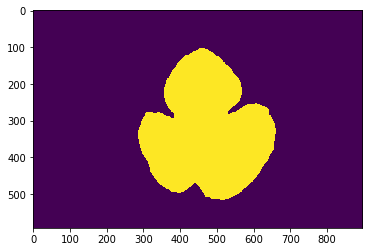

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0089.png: 0.4422932904237817
HC for image_0089.png: 18.110770276274835
DCS for image_0089.png: 0.9918461958003818


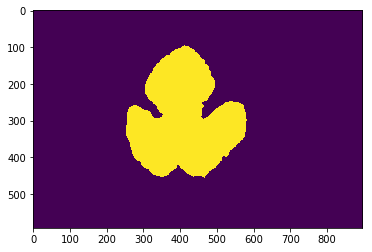

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0090.png: 0.5375126022833051
HC for image_0090.png: 20.09975124224178
DCS for image_0090.png: 0.9918086380299591


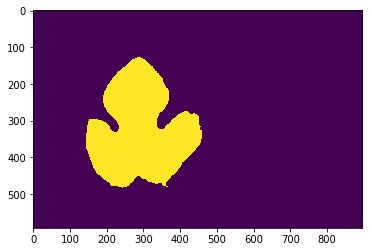

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0099.png: 28.084567732075598
HC for image_0099.png: 232.31228981696168
DCS for image_0099.png: 0.3668171942716094


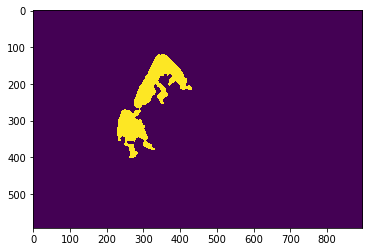

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0100.png: 30.76022190945375


HC for image_0100.png: 106.53168542738823
DCS for image_0100.png: 0.8068311453917012


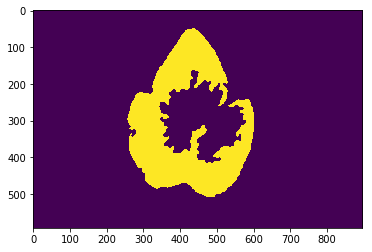

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0104.png: 29.673143952066503


HC for image_0104.png: 106.40018796975878
DCS for image_0104.png: 0.8104483751542575


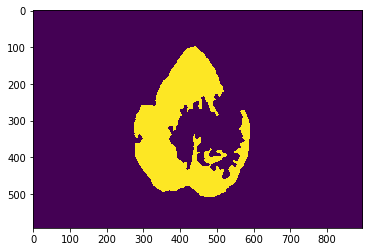

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0105.png: 10.832905516378556
HC for image_0105.png: 69.00724599634447


DCS for image_0105.png: 0.9409154545238829


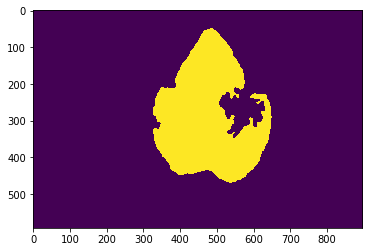

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0110.png: 20.234868096173585
HC for image_0110.png: 153.08167754502824
DCS for image_0110.png: 0.7572682476131813


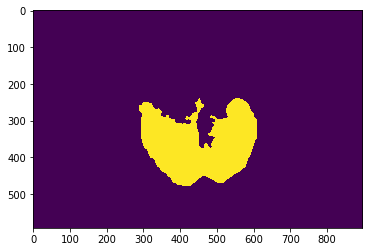

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0113.png: 29.33680141157104
HC for image_0113.png: 177.49647883831386
DCS for image_0113.png: 0.5231790058881549


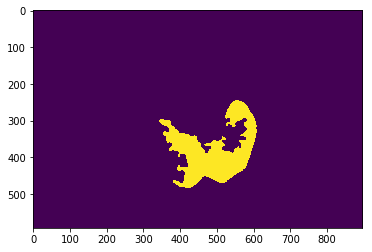

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0132.png: 0.651450643037825
HC for image_0132.png: 5.830951894845301
DCS for image_0132.png: 0.9922619518150597


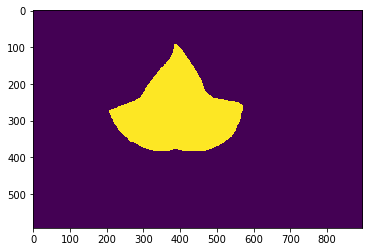

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0160.png: 0.6547973290468844
HC for image_0160.png: 4.242640687119285
DCS for image_0160.png: 0.9925959205678857


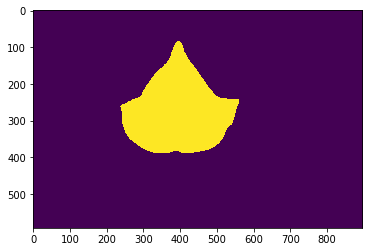

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0161.png: 1.238336411075462
HC for image_0161.png: 4.242640687119285
DCS for image_0161.png: 0.9876287168109581


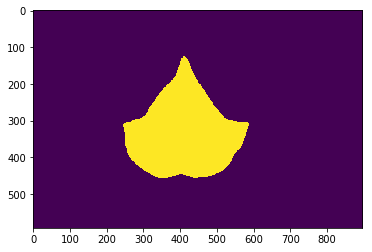

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0162.png: 0.7835700818162115
HC for image_0162.png: 5.0
DCS for image_0162.png: 0.9918142605058493


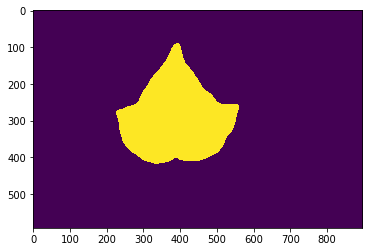

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0163.png: 0.7411472027965912
HC for image_0163.png: 3.605551275463989
DCS for image_0163.png: 0.9919323984896119


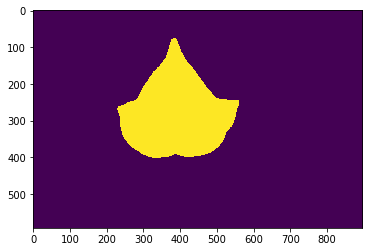

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0165.png: 0.777132751877218
HC for image_0165.png: 3.605551275463989
DCS for image_0165.png: 0.9917823366310093


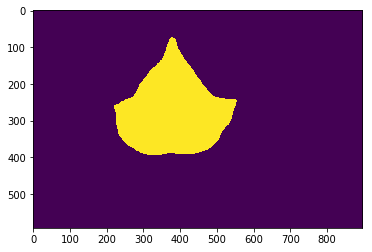

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0166.png: 0.970473413583094
HC for image_0166.png: 5.830951894845301
DCS for image_0166.png: 0.9899340200731804


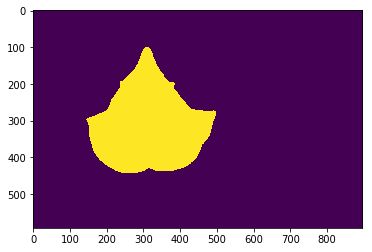

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0171.png: 0.749154912615886
HC for image_0171.png: 19.4164878389476
DCS for image_0171.png: 0.9889333333333333


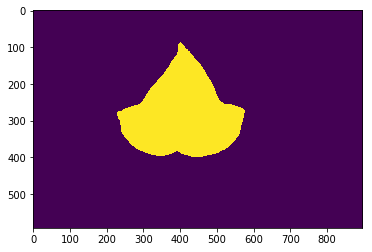

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0174.png: 1.286582903229224
HC for image_0174.png: 12.041594578792296
DCS for image_0174.png: 0.985527836184198


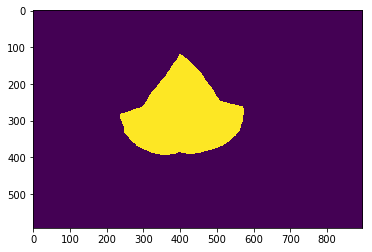

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


MSC for image_0175.png: 0.8534691957839485
HC for image_0175.png: 6.708203932499369
DCS for image_0175.png: 0.9898132872443501


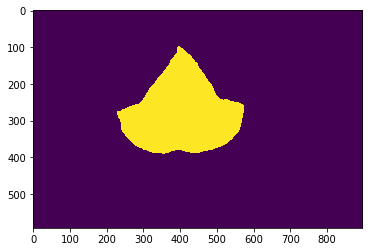

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [71]:
#### Validate ####

# Paths for folders -- original and ground truth images
images_path = os.path.join('.', 'images')
gt_path = os.path.join('.', 'groundtruth')


# Iterate over all files in the original images folder

for root, dirs, files in os.walk(images_path):
    for filename in files:
        # ignore files that are not PNG files.
        if filename[-4:] != '.png':
            continue
        
        # concatenate variable root with filename to get the path to an input file.
        curImName = os.path.join(images_path,filename)
        curGtName = "thresh"+filename
        curGtName = os.path.join(gt_path,curGtName)
        
        curIm = io.imread(curImName)
        curGt = io.imread(curGtName)
        
        I = segleaf(curIm)
        iBoundry = np.where(seg.find_boundaries(I > 0,connectivity=2,mode='inner') > 0)
        iBoundry = np.transpose(np.vstack(iBoundry))
        gtBoundry = np.where(seg.find_boundaries(curGt > 0,connectivity=2,mode='inner') > 0)
        gtBoundry = np.transpose(np.vstack(gtBoundry))
        
        print("MSC for "+filename+": "+str(MSD(iBoundry,gtBoundry)))
        print("HC for "+filename+": "+str(HD(iBoundry,gtBoundry)))
        print("DCS for "+filename+": "+str(DSC(I,curGt)))
        plt.figure()
        plt.imshow(I)
        plt.show()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


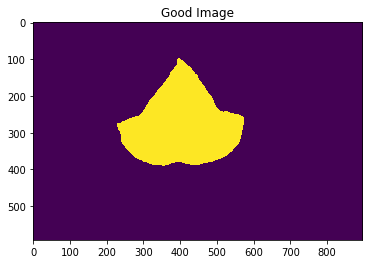

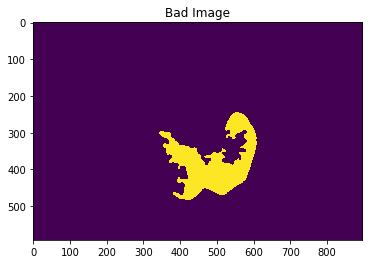

In [72]:
import matplotlib.pyplot as plt

% matplotlib inline
images_path = os.path.join('.', 'images')

gName =  os.path.join(images_path,"image_0175.png")
goodImage = io.imread(gName)
goodImageF = segleaf(goodImage)

bName =  os.path.join(images_path,"image_0113.png")
badImage = io.imread(bName)
badImageF = segleaf(badImage)

plt.figure(1)
plt.title("Good Image")
plt.imshow(goodImageF)

plt.figure(2)
plt.title("Bad Image")
plt.imshow(badImageF)

plt.show()

# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  First, a "greeness" image is made by increasing the weight of the green channel and subtracting the red and blue channels. This results in a black and white image of the green intensities. Next a threshold is applied, the value was found through experimentation. Then filters are applied to remove noise. Small objects are then removed. Then a dilation follwed by an erosion with a hole removal in between is applied to remove any holes. Next each region is labeled and the largest region(which will always be the leaf) is selected and returned.

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  The result could be better if an algorithm that uses less post processing is devoloped. The post processing can remove alot of information.

3. Consider your bad result.  What is it about your algoirthm caused the poor performance?   If you weren't able to get any results, leave this blank.

	_Your answer:_  The poor performance was caused by my "greeness" factor. I did not have a good way to seperate the greens in the leaf from the greens in other parts of the image.
